In [2]:
using Polynomials
using DSP
using Plots
using FFTW
pyplot()

include("..\\..\\Model_Reduction.jl")

Nex = 2^10;
Theta = 2pi*(0:Nex-1)/(Nex-1);
Z = map(th -> exp(im*th),Theta);

# AR(1) Signal and with Additive White Noise

In [3]:
r = .7

sig_v = 1
M_h = 50

50

## A Theoretical Solution

All the details for he formulation of `h_ana` are given in the Wiener Filtering Tutorial.

In [4]:
poly = [r/conj(r), -(1 + sig_v^2*abs(r)^2)/sig_v^2*conj(r), 1]

rho_poly = Polynomial(poly)

Polynomial(1.0 - 1.043*x + 1.0*x^2)

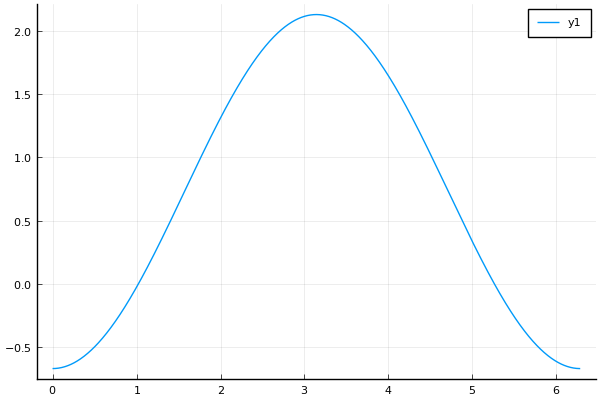

In [5]:
S_x_numerator(z) = - sig_v^2*conj(r)/z*rho_poly(z)

plot(Theta, real.(S_x_numerator.(Z)))

In [6]:
rhos = roots(rho_poly)

2-element Array{Complex{Float64},1}:
 0.5215 - 0.8532512818625002im
 0.5215 + 0.8532512818625002im

In [7]:
rho = rhos[ abs.(rhos) .< 1]

2-element Array{Complex{Float64},1}:
 0.5215 - 0.8532512818625002im
 0.5215 + 0.8532512818625002im

In [8]:
phi0 = conj(rho[1]*rho[2]/r1/r2)/(sig_v)^2;

alpha(n) = sum([rho1^(n-k)*rho2^k for k = 0:n]);
beta(n) = sum([r1^(n-k)*r2^k for k = 0:n]);

M_gam = 1000 + M_h;

A = alpha.(0:M_gam);
B = beta.(0:M_gam);

gamma(n) = sum([conj(A[k])*B[k+n] for k = 1:1000]);

G = gamma.(0:M_h);

F = phi0*conv(G,A[1:M_h+1]);

h_ana = [F[1], F[2] - F[1]*(r1+r2)];

h_temp = [F[n] - (r1 + r2)*F[n-1] + r1*r2*F[n-2] for n = 3 : M_h];

h_ana = [h_ana; h_temp];

UndefVarError: UndefVarError: rho1 not defined

## Data and Numerical Solution

In [175]:
l = [1, -(r1 + r2), r1*r2];

Here we generate the data

In [176]:
steps = 1*10^6
discard = 10^3
steps_tot = steps + discard

noise_sig = randn(steps_tot)
sig = zeros(steps_tot);

sig[1:2] = noise_sig[1:2];
for i = 3 : steps_tot
    sig[i] = dot(-reverse(l)[1:2],sig[i - 2:i-1]) + noise_sig[i]
end
sig = sig[discard + 1 : steps_tot];

noise_pred = sig_v*randn(steps)
pred = sig .+ noise_pred;

In [177]:
function z_crossspect(sig,pred,L; win = "Bart")
    lags = -L:L;
    C = crosscov(sig,pred,lags)
    if win == "Bar"
        lam = 1 .- (0:L)/L
    elseif win == "Tuk"
        lam = .5*(1 .+ cos.(pi/L*(0:L)))
    elseif win == "Par"
        LL = Int(floor(L/2))
        lam1 = 1 .- 6*((0:LL)/L).^2 .+ 6*((0:LL)/L).^3
        lam2 = 2*(1 .- (LL+1:L)/L).^3
        lam = [lam1; lam2]
    else
        lam = ones(L+1)
    end

    z_crossspect_num(z) = sum([lam[abs(i) + 1]*C[L+1+i]*z^(-i) for i = -L : L])
end

z_crossspect (generic function with 1 method)

Here is the code for computuing the wiener filter:

`h_num = wiener_filter_Nu(pred,sig);`

In [178]:
#function wiener_filter_Nu(pred, sig, M_out = 513; par::Int64 = 55, Nex::Int64 = 2^10)
Nex = 2^10;
M_out = 513; 
par = 55;

In [179]:
Theta = 2pi*(0:Nex-1)/(Nex-1);
Z = map(th -> exp(im*th),Theta);

M = par
R_pred = autocov(pred,0:M)

#     Smoothing
LL = Int(floor(M/2))
lam1 = 1 .- 6*((0:LL)/M).^2 .+ 6*((0:LL)/M).^3
lam2 = 2*(1 .- (LL+1:M)/M).^3
lam = [lam1; lam2]

R_pred = R_pred.*lam
l = Scalar_CKMS_c(R_pred);

In [180]:
z_crossspect_sigpred_num = z_crossspect(sig, pred, par, win = "Par");

In [181]:
# # Here we test the code step-by-step against the analytic solution (if the cell
# # begins with a comemnt it is not actuall code of the function)

# # S_{xy}(z)
# # Analitic:
# z_crossspect_sigpred_ana(z) = ( (1+r1*z^(-1))*(1+r2*z^(-1))*(1+conj(r1)*z)*(1+conj(r1)*z) )^(-1);

# # Here I replace the approximated S_{xy}(z) with the analytic one.
# z_crossspect_sigpred_num = z_crossspect_sigpred_ana

In [182]:
# plot(Theta,([z_crossspect_sigpred_num.(Z) z_crossspect_sigpred_ana.(Z)]),
#     color = [:black :red],
#     line = ([:dot :dash],2))

In [183]:
z_spect_pred_minus_num(z) = sum([l[i+1]z^(-i) for i = 0:M])

z_spect_pred_minus_num (generic function with 1 method)

In [184]:
# # Here I replace the approximated S_{xy}(z) with the analytic one.

# z_spect_pred_minus_ana(z) = phi0*(1-rho1*z^(-1))*(1-rho2*z^(-1))/((1-r1*z^(-1))*(1-r2*z^(-1)))

# z_spect_pred_minus_num(z) = z_spect_pred_minus_ana(z)

In [185]:
z_spect_pred_plus_num(z) = z_spect_pred_minus_num(z)'

z_spect_pred_plus_num (generic function with 1 method)

In [186]:
# This computes the impule response (coefficeints of z) for S_{yx}/S_x^+
S_sigpred_overS_plus_fft_num = fft(z_crossspect_sigpred_num.(Z)./z_spect_pred_plus_num.(Z))/Nex;

In [187]:
Nexh = Int(floor(Nex/2))
S_sigpred_overS_plus_fft_plus_num = [S_sigpred_overS_plus_fft_num[1]; 
    zeros(Nexh - 1); S_sigpred_overS_plus_fft_num[Nexh + 1:end]];

S_sigpred_overS_plus_plus_num = ifft(S_sigpred_overS_plus_fft_plus_num)*Nex;

In [188]:
# # Here I plot the causal part of S_{yx}/S^+_{x}
# # Analitical solution:
# CP(z) = sum([G[i+1]*z^(-i) for i = 0:M_h])

# CP_set = CP.(Z)

# plot(Theta, [real.(S_sigpred_overS_plus_plus_num) real.(CP_set)])

# # Here I replace \{S_{yx}/S^+_{x}\}_+ with the analytical solution
# S_sigpred_overS_plus_plus_num = CP_set

In [189]:
H_num = S_sigpred_overS_plus_plus_num./z_spect_pred_minus_num.(Z);
h_num_raw = fft(H_num)/Nex;

In [190]:
h_num = [h_num_raw[1]; reverse(h_num_raw)[1:Nexh]]

h_num[1:M_out];

Now to verify the preformance.

error_num = 0.6726708090571827
error_ana = 0.6723723269295967

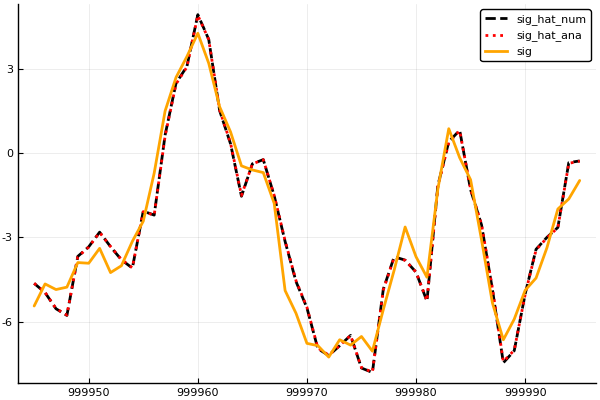

In [191]:
sig_hat_num = conv(real.(h_num),pred)[1:steps]
sig_hat_ana = conv(real.(h_ana),pred)[1:steps]

view = 50
start = 10^6 - 55
tim = start:start + view;

error_num = sum((sig .- sig_hat_num).^2)/steps;
error_ana = sum((sig .- sig_hat_ana).^2)/steps;

print("error_num = ",error_num,"\n")
print("error_ana = ",error_ana)

plot(tim,[sig_hat_num[tim] sig_hat_ana[tim] sig[tim]],
    color=[:black :red :orange ], 
    line=(2,[:dash :dot :solid]),
    label=["sig_hat_num" "sig_hat_ana" "sig"])


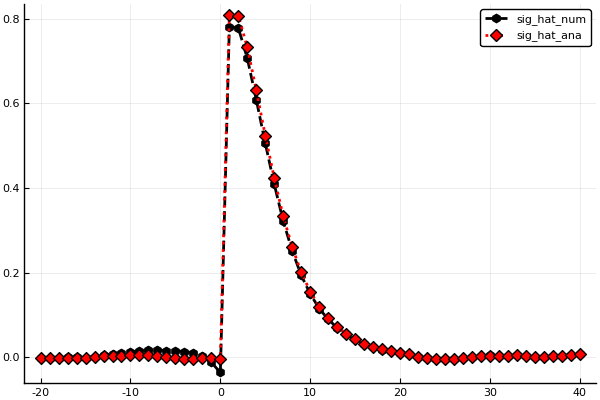

In [192]:
error_num = sig .-sig_hat_num
error_ana = sig .-sig_hat_ana
lags = -20:40
C_ana = crosscov(error_ana,pred,lags)
C_num = crosscov(error_num,pred,lags)
plot(lags, [C_num C_ana],
    color=[:black :red],
    line=(2,[:dash :dot]),
    label=["sig_hat_num" "sig_hat_ana"],
    marker=([:hex :d],6))

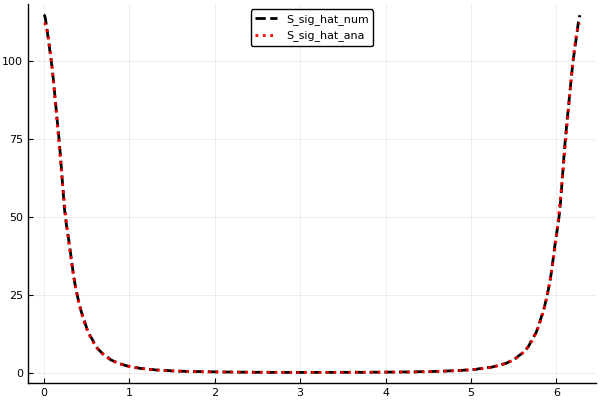

In [193]:
Theta = 2*pi*(0:Nex - 1)/Nex
Z = exp.(im*Theta);

S_sig_hat_num = z_crossspect(sig_hat_num,sig_hat_num,70; win = "Bart")

H(z) = sum([h_ana[i+1]*z^(-i) for i = 0 : M_h-1]);
S_pred(z) = (conj(r1*r2)*rho_poly(z)/z^2)/((1-r1*z^(-1))*(1-r2*z^(-1))*(1-conj(r1)*z)*(1-conj(r2)*z));
S_sig_hat_ana(z) = H(z)*S_pred(z)*conj(H(conj(z)^(-1)));

plot(Theta,[real.(S_sig_hat_num.(Z)) real.(S_sig_hat_ana.(Z))],
    color=[:black :red],line=(2,[:dash :dot]),label=["S_sig_hat_num" "S_sig_hat_ana"])